#decision tree classifier 사용하여 유방암 양성(2), 악성(4) 이진분류 모델로 정의

In [ ]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.2 MB/s eta 0:00:00


## 기본 패키지 import

In [ ]:
import pandas as pd  # 데이터 전처리
import numpy as np

import matplotlib.pyplot as plt # 차트
import seaborn as sns
import koreanize_matplotlib

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics # 성능평과 결과

## 데이터 준비하기

*   https://archive.ics.uci.edu/datasets
*   UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기



In [ ]:
# UCI ML Repository 제공하는 Breast Cancer 데이터셋 가져오기
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

# 데이터 확인 - nan header


df = pd.read_csv(uci_path, header = None)

'''1. Sample code number:            id number
2. Clump Thickness:               1 - 10
3. Uniformity of Cell Size:       1 - 10
4. Uniformity of Cell Shape:      1 - 10
5. Marginal Adhesion:             1 - 10
6. Single Epithelial Cell Size:   1 - 10
7. Bare Nuclei:                   1 - 10
8. Bland Chromatin:               1 - 10
9. Normal Nucleoli:               1 - 10
10. Mitoses:                       1 - 10
11. Class: . Class: '''

df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']
df

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


## 데이터 전처리

In [ ]:
# df['bare_nuclei'] -> object -> '?' -> np.nan변경 -> nan 삭제 -> 컬럼 int로 형변환
df['bare_nuclei'].unique()

# 왜  바로 '?' 안 지우나?
''' 아직 정해지지 않은 값nan으로 변경 ->fillna/dropna 중 1로 선택 가능, 즉 메소드로 처리해야함 '''

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [ ]:
#np.nan변경

df['bare_nuclei'].replace('?', np.nan, inplace = True)
df['bare_nuclei'].isna().sum()

16

In [ ]:
#df['bare_nuclei'] nan data 삭제

df.dropna(subset = ['bare_nuclei'], axis=0,inplace = True)
df['bare_nuclei'].isna().sum()

0

In [ ]:
# int 형으로 형변환

df['bare_nuclei'] = df['bare_nuclei'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


## 데이터 분석(feature 확인)

### 예측하고자하는 target의 비율 확인
(class 컬럼)

In [ ]:
#class (2 for benign, 4 for malignant) 비율확인 -> 데이터셋의 불균형, 균형 확인

df['class'].value_counts()

2    444
4    239
Name: class, dtype: int64

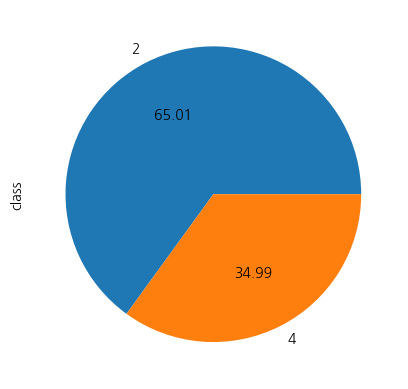

In [ ]:
# 파이차트로 비율 확인
df['class'].value_counts().plot.pie(autopct='%.2f');

In [ ]:
# bar차트로 비율 확인
df['class'].value_counts().plot.bar;


### 타깃과 피쳐들 관의 연관성 확인

In [ ]:
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


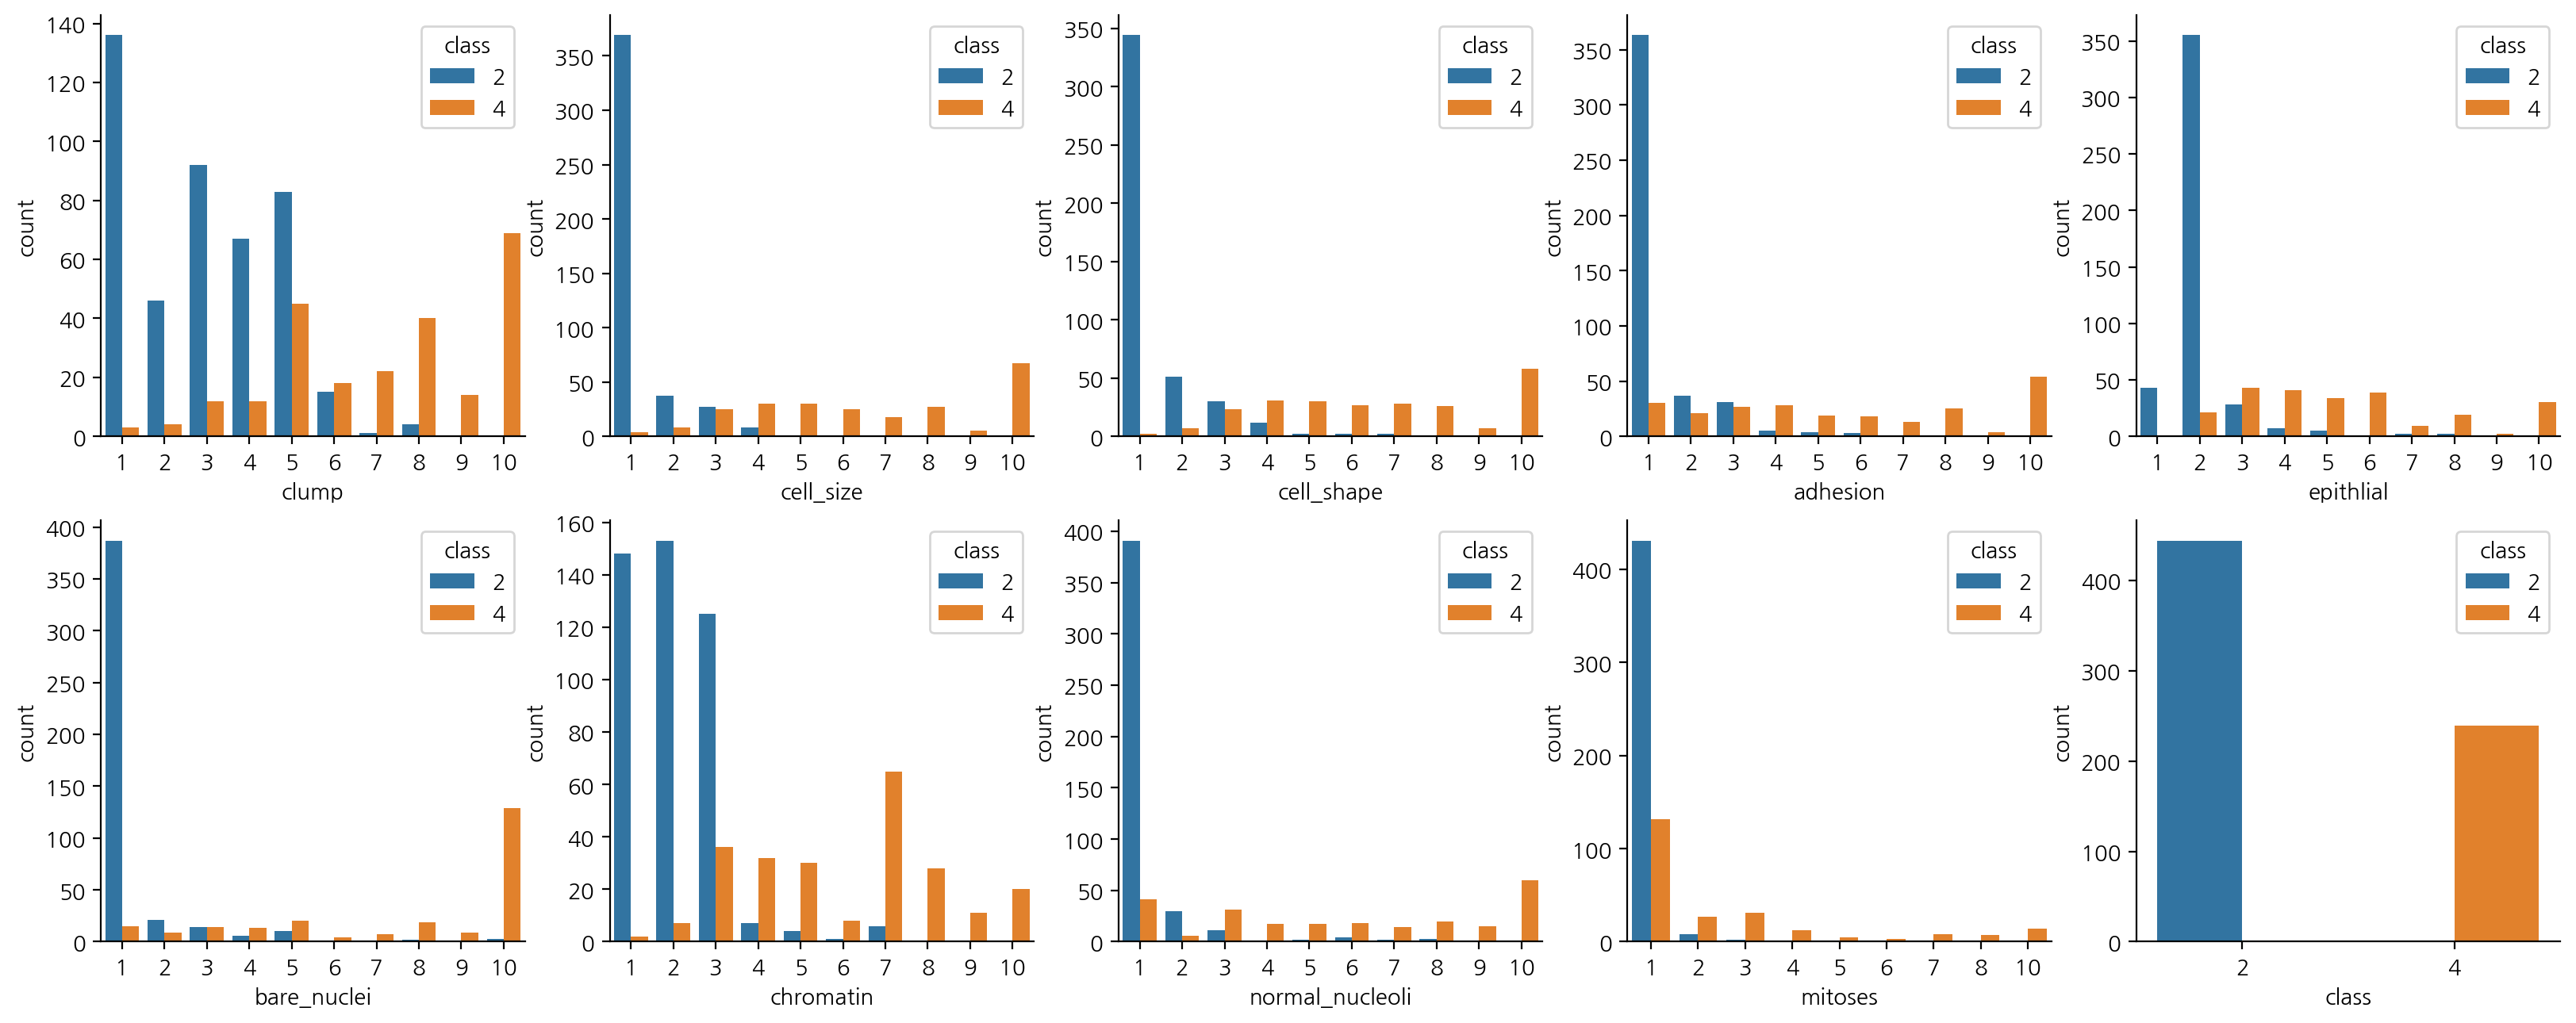

In [ ]:
#id 컬럼 제외하고 target 과 feature의 연관성 확인

attrs = df.columns[1:]

plt.figure(figsize =(20,20),dpi = 200)

for i, feature in enumerate(attrs):
  plt.subplot(5,5,i+1)
  sns.countplot(df, x=feature, hue='class')

sns.despine()


## 데이터 분리

In [ ]:
# x,y로 분리 -> [train/test] set으로 분리


X = df[df.columns[1:-1]] #id, class 컬럼 제외한 feature df
y = df[df.columns[-1]]   # class 컬럼의 target/ series(컬럼이 하나여서..)




,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


In [ ]:
y

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: class, Length: 683, dtype: int64

###  X,y 분리

In [ ]:
# x,y로 분리 -> [train/test] set으로 분리


X = df[df.columns[1:-1]] #id, class 컬럼 제외한 feature df
y = df[df.columns[-1]]   # class 컬럼의 target/ series(컬럼이 하나여서..)

### train, test 분리

In [ ]:
X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=7 )

print('X_train.shape', X_trian.shape)
print('X_test.shape', X_test.shape)



X_train.shape (478, 9)
X_test.shape (205, 9)


In [ ]:
#criterion='entropy' = 최적의 속성을 찾기 위해서, 적정한 레벨 값을 찾기 위해 =  max_depth=5

tree_model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)

In [ ]:
tree_model.fit(X_trian, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [ ]:
y_pred = tree_model.predict(X_test)

In [ ]:
print("훈련 데이터셋 정확도:",tree_model.score(X_trian, y_train))
print("훈련 테스트셋 정확도:",tree_model.score(X_test, y_test))

훈련 데이터셋 정확도: 0.9769874476987448
훈련 테스트셋 정확도: 0.9463414634146341


In [ ]:
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

              precision    recall  f1-score   support

           2       0.98      0.94      0.96       133
           4       0.90      0.96      0.93        72

    accuracy                           0.95       205
   macro avg       0.94      0.95      0.94       205
weighted avg       0.95      0.95      0.95       205



In [ ]:
#print('accurary:', metrics.precision_score(y_test, y_pred))
#print('presion:', metrics.precision_score(y_test, y_pred))
#print('recall:', metrics.precision_score(y_test, y_pred))
#print('f1:', metrics.precision_score(y_test, y_pred))

## 결정트리 그래프 그리기

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree_model, out_file='tree.dot', class_names =['양성','악성'],
                feature_names=df.columns[1:10], impurity=False, filled=True)

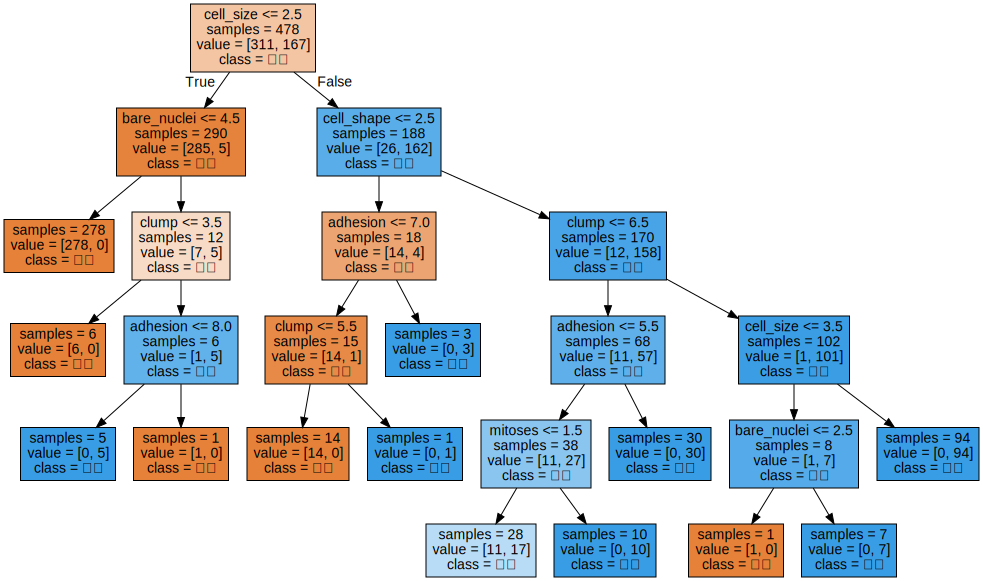

In [ ]:
import graphviz

with open('tree.dot') as f:
  dot_graph = f.read()

display(graphviz.Source(dot_graph))

## max_depth 변화에 따른 성능 평가

In [ ]:
# 1~10까지 max_depth를 변화시켜 가장 최적의max_depth 찾기

train_scores = {}
test_scores = {}

for i in np.arange(1, 11):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i).fit(X_trian, y_train)
    train_scores[i] = tree_model.score(X_trian, y_train)
    test_scores[i] = tree_model.score(X_test, y_test)

max_train_key = max(train_scores, key=train_scores.get)
max_test_key = max(test_scores, key=test_scores.get)

print("훈련 데이터셋 최적의 max_depth:", max_train_key, '정확도: ', train_scores[max_train_key])
print("테스트 데이터셋 최적의 max_depth:", max_test_key, '정확도: ', test_scores[max_test_key])

훈련 데이터셋 최적의 max_depth: 10 정확도:  1.0
테스트 데이터셋 최적의 max_depth: 6 정확도:  0.9512195121951219


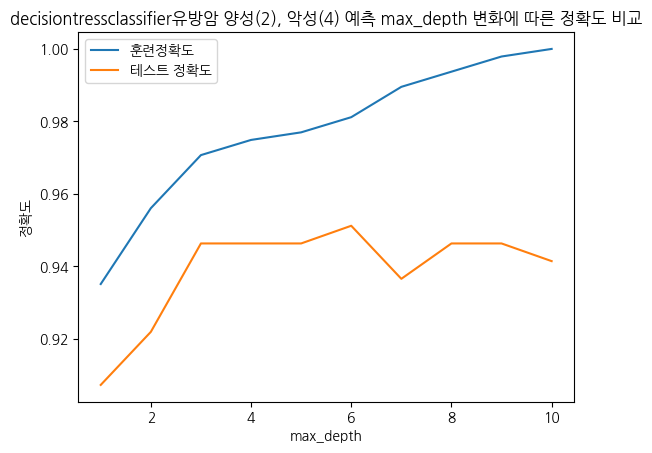

In [ ]:
plt.title('decisiontressclassifier유방암 양성(2), 악성(4) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(train_scores.keys(), train_scores.values(), label = '훈련정확도')
plt.plot(test_scores.keys(), test_scores.values(), label = '테스트 정확도')

plt.ylabel('정확도')
plt.xlabel('max_depth')
plt.legend()
plt.show()

#decision tree classifier 사용하여 유방암 양성(0), 악성(1) 이진분류 모델로 정의


*   class 컬럼의 값을 2->0, 4->1로 변경
*   X,y로 분리 후 X값 정규화(preprocessing.StandardScaler() 사용)
*   Max_depth 1~20 변환하여, 최적점 찾기
*   최적점 적용한 모델 성능평가(accurary, precision, recall, f1)
*   모델 그래프 그리기



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


In [ ]:
df['class']

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: class, Length: 683, dtype: int64

###클래스 레이블 변경

In [ ]:
# 교수님 코드

df['target'] = np.where(df['class'] == 2, 0,1)

# 파이 차트로 확인 가능

In [ ]:
y[y == 2] = 0
y[y == 4] = 1

In [ ]:
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [ ]:
df['class']

0      0
1      0
2      0
3      0
4      0
      ..
694    0
695    0
696    1
697    1
698    1
Name: class, Length: 683, dtype: int64

### x,y로 분류

In [ ]:
# x,y로 분리 -> [train/test] set으로 분리

X = df[df.columns[1:-1]] # id, class 컬럼 제외한 feature 데이터프레임
y = df[df.columns[-1]] # class 컬럼만 target 시리즈

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)  # fit().transform()
X

array([[ 0.19790469, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       [ 0.19790469,  0.27725185,  0.26278299, ..., -0.18182716,
        -0.28510482, -0.34839971],
       [-0.51164337, -0.70221201, -0.74177362, ..., -0.18182716,
        -0.61292736, -0.34839971],
       ...,
       [ 0.19790469,  2.23617957,  2.2718962 , ...,  1.86073779,
         2.33747554,  0.22916583],
       [-0.15686934,  1.58320366,  0.93248739, ...,  2.67776377,
         1.02618536, -0.34839971],
       [-0.15686934,  1.58320366,  1.6021918 , ...,  2.67776377,
         0.37054027, -0.34839971]])

In [ ]:
X_trian, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=7 )

print('X_train.shape', X_trian.shape)
print('X_test.shape', X_test.shape)

X_train.shape (478, 9)
X_test.shape (205, 9)


In [ ]:
# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

# X값 정규화 하기
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 1~20 까지 max_depth를 변화시켜 가장 최적의 max_depth 찾기

train_scores = {}
test_scores = {}

# tree max_depth 1~10까지 증가시켜 정확도 측정
# range() 소수점 지원 x , --> np.arange() 소수점 지원 가능
for idx in np.arange(1,21):
  tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = idx).fit(X_train, y_train)
  train_scores[idx] = tree_model.score(X_train, y_train)
  test_scores[idx] = tree_model.score(X_test, y_test)


# 훈련, 테스트셋의 가장 높은 정확도의 max_depth 확인

max_test_key = max(test_scores, key = test_scores.get)
max_train_key = max(train_scores, key = train_scores.get)

print('훈련 데이터셋 최적의 max_depth: ', max_train_key, '정확도: ',train_scores[max_train_key])
print('테스트 데이터셋 최적의 max_depth: ', max_test_key, '정확도: ',test_scores[max_test_key])

훈련 데이터셋 최적의 max_depth:  10 정확도:  1.0
테스트 데이터셋 최적의 max_depth:  6 정확도:  0.9512195121951219


accuracy:  0.9512195121951219
precision:  0.9558823529411765
recall:  0.9027777777777778
f1:  0.9285714285714286


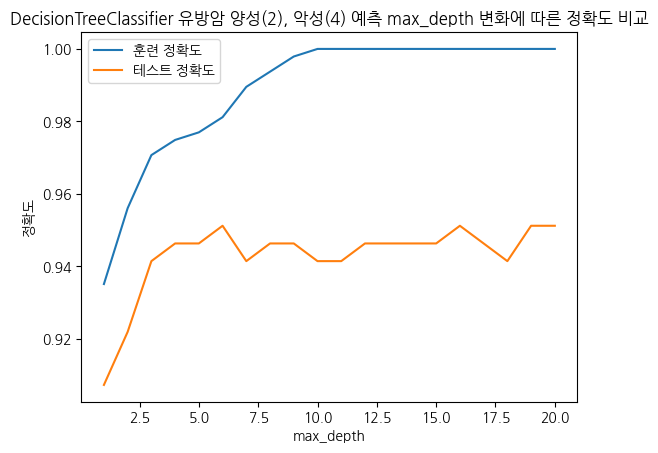

In [ ]:
tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = max_test_key).fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred))
print('recall: ', metrics.recall_score(y_test, y_pred))
print('f1: ', metrics.f1_score(y_test, y_pred))



plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')

plt.plot(train_scores.keys(), train_scores.values(), label = '훈련 정확도')
plt.plot(test_scores.keys(), test_scores.values(), label = '테스트 정확도')
plt.xlabel('max_depth')
plt.ylabel('정확도')
plt.legend()
plt.show()

In [ ]:
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred))
print('recall: ', metrics.recall_score(y_test, y_pred))
print('f1: ', metrics.f1_score(y_test, y_pred))


# recall 실제 정답중 맞춘 비율

accuracy:  0.9512195121951219
precision:  0.9558823529411765
recall:  0.9027777777777778
f1:  0.9285714285714286


## recall 값이 (재현율) 가장 높은 모델을 찾기

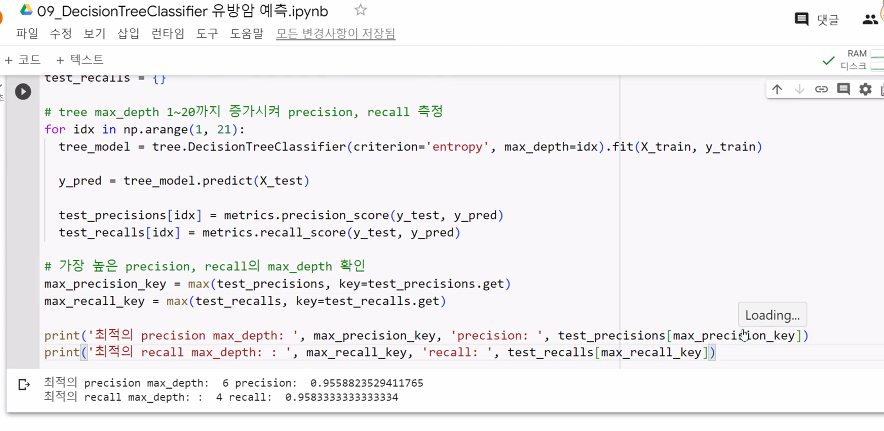

In [148]:
test_precisions = {}
test_recalls = {}

# 결정 트리의 max_depth를 1~20까지 올려서 recall, percision 측정
for idx in np.arange(1, 21) : # np.arange(1, 11) : 증가값 설정하지 않으면 알아서 1씩 증가
  tree_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = idx).fit(X_train, y_train)
  y_pred = tree_model.predict(X_test)
  test_precisions[idx] =  metrics.precision_score(y_test, y_pred)
  test_recalls[idx] =  metrics.recall_score(y_test, y_pred)

max_precision_key = max(test_precisions, key = test_precisions.get)
max_recall_key = max(test_recalls, key = test_recalls.get)

In [149]:
print('최적의 precision max_depth: ', max_precision_key, ', 정확도 : ', test_precisions[max_precision_key])
print('최적의 recall max_depth: ', max_recall_key, ', 정확도 : ', test_recalls[max_recall_key])

최적의 precision max_depth:  6 , 정확도 :  0.9558823529411765
최적의 recall max_depth:  3 , 정확도 :  0.9583333333333334


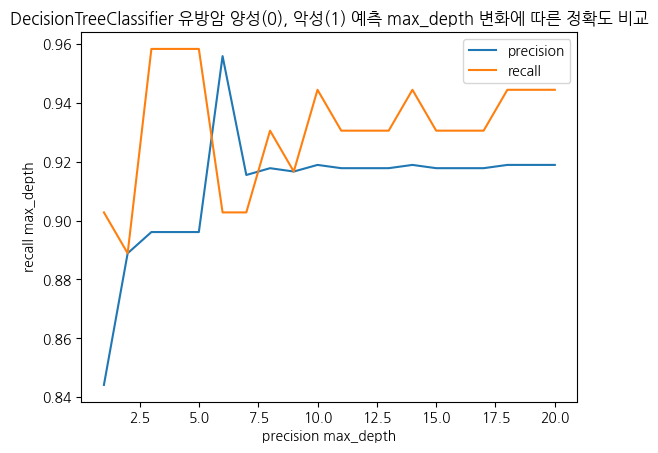

In [150]:
plt.title('DecisionTreeClassifier 유방암 양성(0), 악성(1) 예측 max_depth 변화에 따른 정확도 비교')
plt.plot(test_precisions.keys(), test_precisions.values(), label = 'precision')
plt.plot(test_recalls.keys(), test_recalls.values(), label = 'recall')

plt.xlabel('precision max_depth')
plt.ylabel('recall max_depth')
plt.legend()
plt.show()